In [115]:
import os
import omdb
import csv
import pickle
import collections
import pandas as pd
print(pd.__version__)
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.algorithms import bipartite
from networkx.algorithms import clique
from networkx.algorithms import cluster
from networkx.algorithms import link_prediction
from networkx.algorithms import shortest_paths
from scipy.optimize import curve_fit
from scipy import stats, integrate
import operator
print(nx.__version__)

import statistics

0.19.2
2.0


In [2]:
df = pickle.load(open("databasedump.pickle", 'rb'))

In [4]:
df.describe()

,actors,awards,box_office,country,director,genre,imdb_rating,imdb_votes,language,metascore,plot,production,rated,released,title,writer,year,title_director
count,15673,15673,15431,15673,15673,15673,15673,15673,15673,15673,15673,15431,15673,15673,15673,15673,15673,15673
unique,15267,2350,2900,1160,7035,949,82,10499,1338,98,14990,2089,23,8363,15646,13314,236,15673
top,N/A,N/A,N/A,USA,N/A,Drama,7.2,N/A,English,N/A,N/A,N/A,R,N/A,Seal Team Six: The Raid on Osama Bin Laden,N/A,2004,The House on Sorority Row: Mark Rosman
freq,231,5578,12402,8447,343,1153,683,350,9330,10322,667,3198,4584,653,2,870,538,1


In [5]:
#process dataframe into network
allActors = []
biGraph = nx.Graph()
actorSet = 0
movieSet = 1
count = 0

for index, row in df.iterrows():
    movie = row['title_director']
    biGraph.add_nodes_from([movie], bipartite=movieSet)
    actors = row['actors']
    if isinstance(actors, str):
        actors = actors.split(', ')
        #print(actors)
        for actor in actors:
            if not any(actor == name for name in allActors): # if actor is not in allActors already:
                allActors.append(actor)
                biGraph.add_nodes_from([actor], bipartite=actorSet)
                biGraph.add_edge(movie, actor, weight=1)
            else:
                biGraph.add_edge(movie, actor, weight=1)
    count = count + 1


In [8]:
if(len(biGraph.nodes) > 50):
    print('too many nodes to plot in a reasonable amount of time')
else:
    nx.draw(biGraph)
    plt.show()

too many nodes to plot in a reasonable amount of time


In [9]:
movieNodes = set(n for n, d in biGraph.nodes(data=True) if d['bipartite']==movieSet)
actorNodes = set(n for n, d in biGraph.nodes(data=True) if d['bipartite']==actorSet)
print(len(movieNodes))
print(len(actorNodes))

15674
27352


In [10]:
len(biGraph['Mickey Rooney'])

21

In [11]:
biGraph['Inception: Christopher Nolan']['Leonardo DiCaprio']['weight']

1

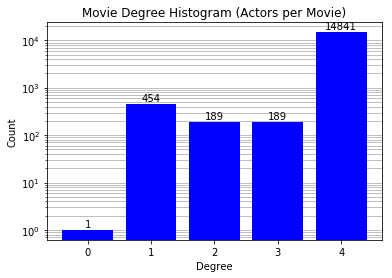

In [16]:
movieDegrees = sorted([d for n, d in biGraph.degree(movieNodes)])
#print(actorDegrees)
degreeCount = collections.Counter(movieDegrees)
degree, count = zip(*degreeCount.items())
fig, ax = plt.subplots()

bars = plt.bar(degree, count, width=0.80, color='b')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

plt.title("Movie Degree Histogram (Actors per Movie)")
plt.ylabel("Count")
plt.yscale("log")
plt.xlabel("Degree")
ax.set_axisbelow(True)
plt.grid(axis='y', which="both")
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 1))

plt.show()

In [11]:
for actor in actorNodes:
    if biGraph.degree(actor) >= 45:
        print(actor + ": " + str(biGraph.degree(actor)))

Michael Caine: 54
John Wayne: 61
Nicolas Cage: 46
Bruce Willis: 48
Stan Laurel: 46
Robert De Niro: 63
James Stewart: 47
N/A: 231
Samuel L. Jackson: 48
Mel Blanc: 87
Oliver Hardy: 50


In [12]:
len(biGraph['N/A'])

231

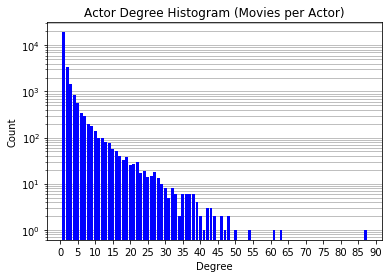

In [18]:
actorMovieDegrees = sorted([d for n, d in biGraph.degree(actorNodes)])
actorMovieDegrees = [i for i in actorMovieDegrees if i != len(biGraph['N/A'])]
#print(actorMovieDegrees)
degreeCount = collections.Counter(actorMovieDegrees)
degree, count = zip(*degreeCount.items())
fig, ax = plt.subplots()
bars = plt.bar(degree, count, width=0.80, color='b')

plt.title("Actor Degree Histogram (Movies per Actor)")
plt.ylabel("Count")
plt.yscale("log")
plt.xlabel("Degree")
ax.set_axisbelow(True)
plt.grid(axis='y', which="both")
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 5))

plt.show()

In [20]:
actorGraphUnweighted = nx.projected_graph(biGraph, actorNodes)
actorGraph = bipartite.weighted_projected_graph(biGraph, actorNodes)

In [15]:
print(actorGraph['James Franco']['Seth Rogen']['weight'])
print(len(actorGraph['James Franco']))

3
53


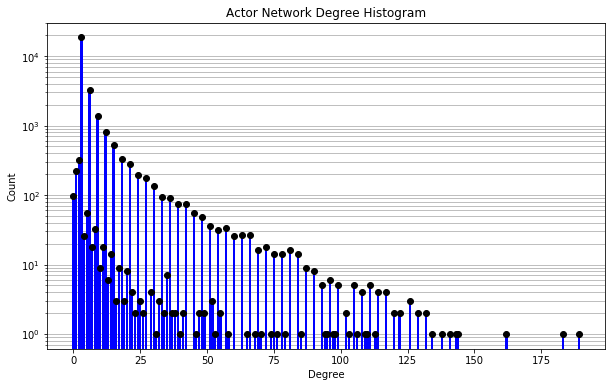

In [69]:
actorDegrees = sorted([d for n, d in actorGraph.degree(weight='weight')])
#print(actorDegrees)
degreeCount = collections.Counter(actorDegrees)
degree, count = zip(*degreeCount.items())

fig, ax = plt.subplots(figsize=(10,6))
plt.bar(degree, count, width=0.80, color='b')
plt.plot(degree, count, 'ko')

plt.title("Actor Network Degree Histogram")
plt.ylabel("Count")
plt.yscale("log")
plt.xlabel("Degree")
plt.xlabel("Degree")
ax.set_axisbelow(True)
plt.grid(axis='y', which="both")
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 25))

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: divide by zero encountered in power
  from ipykernel import kernelapp as app


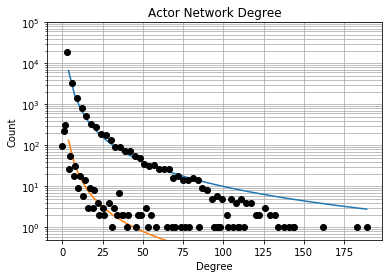

In [26]:
def func(x, a, b, c):
    return a*(x**-b) + c
    #return a*np.exp(-b*x)-c

#popt, pcov = curve_fit(func, degree, count, p0=(50000, 2, 1e-8), maxfev=50000)

xx = np.linspace(min(degree), max(degree))
yy = func(xx, 100000, 2, 0)
yyy = func(xx, 2000, 2, 0)
#yy = func(xx, *popt)

plt.plot(xx, yy)
plt.plot(xx, yyy)
plt.plot(degree, count, 'ko')
plt.title('Actor Network Degree')
plt.yscale('log')
plt.ylabel("Count")
plt.xlabel("Degree")
plt.xlabel("Degree")
ax.set_axisbelow(True)
plt.grid(True, which="both")
plt.ylim([0.5, 10e4])
plt.show()

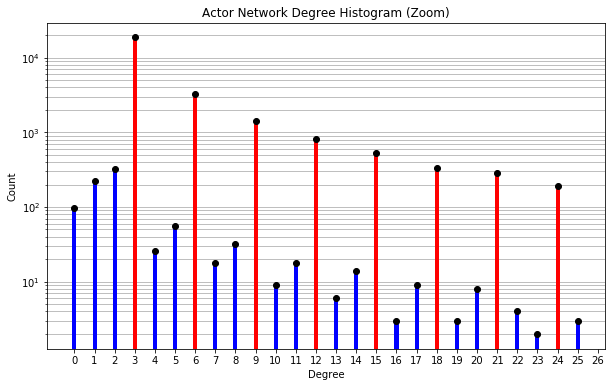

In [68]:
actorDegrees = sorted([d for n, d in actorGraph.degree(weight='weight')])
actorDegrees = [i for i in actorDegrees if i <=25]
#print(actorDegrees)
degreeCount = collections.Counter(actorDegrees)
degreeCount3 = collections.Counter()
degreeCountOth = collections.Counter()
for deg in degreeCount:
    if (deg % 3 == 0) & (deg != 0):
        #print(deg)
        degreeCount3.update({deg:degreeCount[deg]})
    else:
        degreeCountOth.update({deg:degreeCount[deg]})
        
degree3, count3 = zip(*degreeCount3.items())
degreeOth, countOth = zip(*degreeCountOth.items())

fig, ax = plt.subplots(figsize=(10,6))
plt.bar(degree3, count3, width=0.20, color='r')
plt.bar(degreeOth, countOth, width=0.20, color='b')
plt.plot(degree3, count3, 'ko')
plt.plot(degreeOth, countOth, 'ko')

plt.title("Actor Network Degree Histogram (Zoom)")
plt.ylabel("Count")
plt.yscale("log")
plt.xlabel("Degree")
plt.xlabel("Degree")
ax.set_axisbelow(True)
plt.grid(axis='y', which="both")
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 1))

plt.show()

Counter({3: 18552, 6: 3251, 9: 1394, 12: 820, 15: 527, 18: 334, 21: 282, 24: 192, 27: 177, 30: 136, 33: 93, 36: 91, 42: 75, 39: 74, 45: 56, 48: 49, 51: 36, 57: 33, 54: 31, 63: 27, 66: 27, 60: 26, 72: 18, 69: 16, 81: 16, 75: 14, 78: 14, 84: 14, 87: 9, 90: 8, 96: 6, 93: 5, 99: 5, 105: 5, 111: 5, 108: 4, 114: 4, 117: 4, 126: 3, 102: 2, 120: 2, 129: 2, 132: 2, 138: 1, 141: 1, 144: 1, 162: 1, 183: 1, 189: 1})


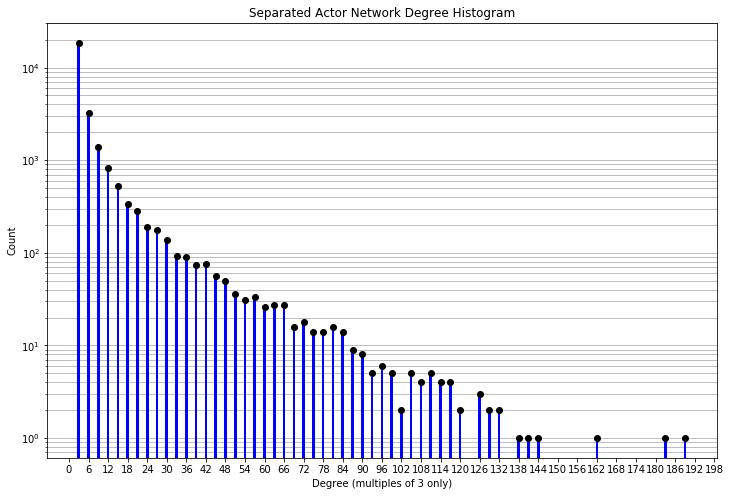

In [63]:
actorDegrees = sorted([d for n, d in actorGraph.degree(weight='weight')])
#actorDegrees = [i for i in actorDegrees if (i >=25) & (i < 50)]
#print(actorDegrees)
degreeCount = collections.Counter(actorDegrees)
degreeCount3 = collections.Counter()
degreeCountOth = collections.Counter()
for deg in degreeCount:
    if (deg % 3 == 0) & (deg != 0):
        #print(deg)
        degreeCount3.update({deg:degreeCount[deg]})
    else:
        degreeCountOth.update()
        

#print(elem, degreeCount[elem])
#print(degreeCount3)
degree, count = zip(*degreeCount3.items())
#degree = degree[::3]
#count = count[::3]
#degree3 = [deg for deg in degree if deg % 3 == 0]


fig, ax = plt.subplots(figsize=(12,8))
plt.bar(degree, count, width=0.80, color='b')
plt.plot(degree, count, 'ko')

plt.title("Separated Actor Network Degree Histogram")
plt.ylabel("Count")
plt.yscale("log")
plt.xlabel("Degree (multiples of 3 only)")
ax.set_axisbelow(True)
plt.grid(axis='y', which="both")
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 6))

plt.show()

[ -2.43711725e+00   2.69280915e+05   2.43454396e+01]
[[  3.64187906e-04  -1.09715737e+02  -5.31982041e-02]
 [ -1.09715737e+02   3.36528986e+07   1.48785969e+04]
 [ -5.31982041e-02   1.48785969e+04   6.79623228e+01]]
0.9996196521532349


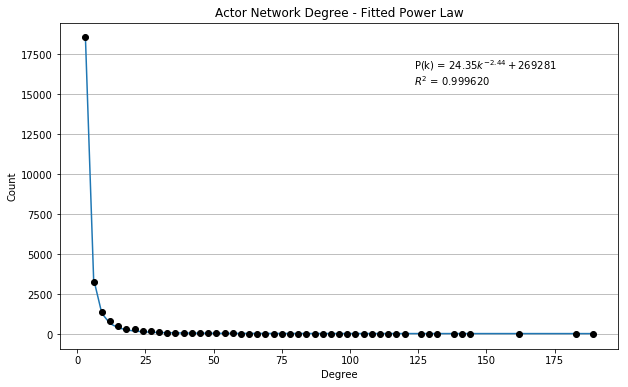

In [76]:
actorDegrees = sorted([d for n, d in actorGraph.degree(weight='weight')])
degreeCount = collections.Counter(actorDegrees)
degreeCount3 = collections.Counter()
degreeCountOth = collections.Counter()
for deg in degreeCount:
    if (deg % 3 == 0) & (deg != 0):
        #print(deg)
        degreeCount3.update({deg:degreeCount[deg]})
    else:
        degreeCountOth.update()
degree, count = zip(*degreeCount3.items())

df = pd.DataFrame({
            'degree': degree,
            'count': count
        })

def func_powerlaw(x, m, c, c0):
    return c0 + x**m * c

target_func = func_powerlaw

X = df['degree']
y = df['count']

popt, pcov = curve_fit(target_func, X, y, maxfev=10000, p0 = np.asarray([-2.5, 10*5, 0])) 
print(popt)
print(pcov)

residuals = y - target_func(X, popt[0], popt[1], popt[2])
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
print(r_squared)

fig, ax = plt.subplots(figsize=(10,6))
#plt.bar(degree, count, width=0.80, color='b')
plt.plot(X, target_func(X, *popt), '-')
plt.plot(X, y, 'ko')

plt.title("Actor Network Degree - Fitted Power Law")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_axisbelow(True)
plt.grid(axis='y', which="both")

startx, endx = ax.get_xlim()
starty, endy = ax.get_ylim()
plt.text(endx - 75, endy - 2900, r'P(k) = $%.2f k^{%.2f} + %.0f$' % (popt[2], popt[0], popt[1]))
plt.text(endx - 75, endy - 3900, r'$R^2$ = %f' %r_squared)
#equation = r'$P(k) = ' + str(round(popt[1], 3)) + '* x^' + str(round(popt[0], 3) + ' + '+ str(round(popt[2], 3))
#text(1,1, equation)

#ax.xaxis.set_ticks(np.arange(0, end, 3))

plt.show()

In [77]:
movieGraph = bipartite.weighted_projected_graph(biGraph, movieNodes)

In [78]:
clusterCoefs = nx.clustering(movieGraph, weight='weight')

In [90]:
actorClusterCoefs = nx.clustering(actorGraph, weight='weight')

In [93]:
print(len(clusterCoefs))
print(type(clusterCoefs))
print(clusterCoefs['Bachelor Mother: Garson Kanin'])
movieValues = [clusterCoefs[key] for key in clusterCoefs]
avgClusterCoefMovies = statistics.mean(movieValues)
print(avgClusterCoefMovies)

15674
<class 'dict'>
0.08743623819570166
0.11201238384298931


In [95]:
print(len(actorClusterCoefs))
print(type(actorClusterCoefs))
print(actorClusterCoefs['Mel Blanc'])
actorValues = [actorClusterCoefs[key] for key in actorClusterCoefs]
avgClusterCoefActors = statistics.mean(actorValues)
print(avgClusterCoefActors)

27352
<class 'dict'>
0.0015613164880761373
0.01771229637528495


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



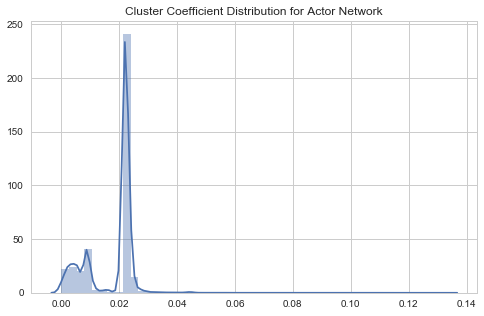

James Doohan
0.13333333333333336


In [132]:
fig, ax = plt.subplots(figsize=(8,5))
sns.distplot(actorValues)
plt.title('Cluster Coefficient Distribution for Actor Network')
plt.show()

print(max(actorClusterCoefs.items(), key=operator.itemgetter(1))[0])
print(max(actorClusterCoefs.items(), key=operator.itemgetter(1))[1])

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



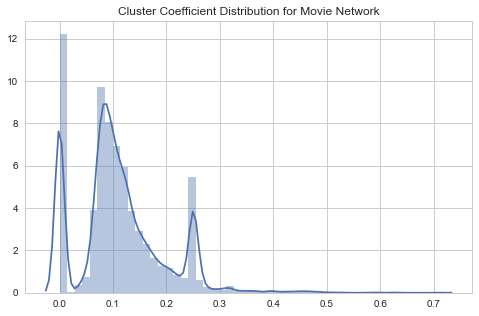

Duck Soup: Leo McCarey


In [128]:
fig, ax = plt.subplots(figsize=(8,5))
sns.distplot(movieValues)
plt.title('Cluster Coefficient Distribution for Movie Network')
plt.show()

print(max(clusterCoefs.items(), key=operator.itemgetter(1))[0])

In [ ]:
length = dict(nx.all_pairs_shortest_path_length(actorGraph))

In [136]:
length


TypeError: 'generator' object is not subscriptable